In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload
sys.path.append("D:/DST/")
import cathay_db as db
import utils as ut
import financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [3]:
# select model 
model_folder_name = '20230706_141045'

In [4]:
# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

In [5]:
setting.keys()

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search'])

In [6]:
# create a list for model json file in model/model_folder_name
model_list = []
for model in os.listdir(f'./models/{model_folder_name}'):
    if model.endswith('.json'):
        # append the model path to model_list
        model_list.append(f'./models/{model_folder_name}/{model}')
# sort model_list
model_list.sort()

In [7]:
model = xgb.Booster()
model.load_model(model_list[0])

In [8]:
model_list[0]

'./models/20230706_141045/20060116.json'

In [9]:
model = xgb.Booster()

model.load_model(model_list[0])

In [34]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all.feather')

df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = setting['rebalance_date_lst'][setting['start_index'] + 0:]
df_model_mapping['model_path'] = model_list
# convert rebalance_date to datetime
df_model_mapping['rebalance_date'] = pd.to_datetime(df_model_mapping['rebalance_date'])

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
df_factor_all.dropna(subset=['model_path'], inplace=True)

In [35]:
reb_lst = df_factor_all['rebalance_date'].unique()
model_list

In [37]:
factor_columns = setting['factor_columns']

In [59]:
df_predict_all = pd.DataFrame([])
df_feature_importance_all = pd.DataFrame([])
for i, model_path in enumerate(model_list):
    model = xgb.Booster()
    model.load_model(model_path)

    df_feature_importance = pd.DataFrame(model.get_score(importance_type='gain').items(), columns=['feature','importance'])
    df_feature_importance.sort_values('importance', ascending=False, inplace=True)
    df_feature_importance['date'] = reb_lst[i]
    df_feature_importance_all = pd.concat([df_feature_importance_all, df_feature_importance], axis=0)

    df_predict = df_factor_all[df_factor_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
    df_predict['predict'] = model.predict(xgb.DMatrix(df_predict[factor_columns]))
    df_predict_all = pd.concat([df_predict_all, df_predict], axis=0)

In [62]:
df_feature_importance_all.groupby('feature')['importance'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
feature,,,,,,,,
excess_return,68.0000,6.0547,2.6034,0.8613,5.1541,6.5080,7.9617,9.6449
dividend_3Y_sum_yield,68.0000,3.4282,2.0865,0.4175,1.7640,2.9927,5.4081,7.4012
roe,68.0000,3.2915,0.7745,1.2942,2.8133,3.7138,3.9348,4.1383
ni_qoq,68.0000,3.1072,0.8089,0.6654,2.8437,3.3152,3.5688,4.3699
tobins_q,68.0000,3.1016,1.2727,0.5609,2.5214,3.0731,4.0476,6.1974
last_dividend_yield,65.0000,2.8112,1.2099,0.4787,2.0252,2.4257,4.0086,5.0758
roe_yoy,68.0000,2.4990,1.0534,0.4509,1.8833,2.2832,3.4629,5.0157
dividend_2Y_sum_yield,67.0000,2.3983,1.2720,0.3677,1.3046,2.5070,3.2357,4.8338
roe_4q_sum,68.0000,1.9056,0.7282,0.9613,1.3659,1.5984,2.5602,3.3826


In [79]:
i = 0

df_predict_describe_all = pd.DataFrame([])

for i in range(len(reb_lst)):
    df_predict = df_predict_all[df_predict_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
    # calc predict qcut
    df_predict['predict_qcut'] = pd.qcut(df_predict['predict'], 10, labels=False, duplicates='drop')
    df_predict_describe = df_predict.groupby('predict_qcut')['y'].describe().reset_index()
    df_predict_describe['date'] = reb_lst[i]
    df_predict_describe_all = pd.concat([df_predict_describe_all, df_predict_describe], axis=0)

In [83]:
df_predict_describe_all.groupby('predict_qcut')['mean'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
predict_qcut,,,,,,,,
9,68.0000,0.0478,0.1332,-0.1979,-0.0357,0.0299,0.1035,0.6154
8,68.0000,0.0223,0.1285,-0.2652,-0.0560,-0.0004,0.0559,0.5928
7,68.0000,0.0179,0.1184,-0.2467,-0.0447,-0.0044,0.0442,0.5431
6,68.0000,0.0123,0.1169,-0.2340,-0.0560,-0.0079,0.0399,0.5562
5,68.0000,0.0102,0.1191,-0.2347,-0.0591,-0.0128,0.0332,0.5868
4,68.0000,0.0042,0.1111,-0.2359,-0.0602,-0.0170,0.0279,0.4952
3,68.0000,-0.0003,0.1142,-0.2284,-0.0603,-0.0241,0.0234,0.5308
2,68.0000,-0.0021,0.1085,-0.2173,-0.0659,-0.0267,0.0221,0.4613
1,68.0000,-0.0047,0.1078,-0.2028,-0.0618,-0.0237,0.0150,0.4182


In [108]:
df_predict_all = df_predict_all[df_predict_all['date'].isin(reb_lst)]
df_predict_all['predict_group'] = df_predict_all.groupby('date',group_keys=False)['predict'].apply(lambda x :pd.qcut(x,10,labels=False))
df_predict_all['predict_rank'] = df_predict_all.groupby('date',group_keys=False)['predict'].rank(ascending=False)
df_select = df_predict_all[df_predict_all['predict_rank']<=50]
df_select_return = df_select.groupby('date')['y'].mean()

In [113]:
(df_select_return+1).cumprod()
((df_select_return+1).prod()**(4/len(b))-1 )/(df_select_return.std()*np.sqrt(4))

0.9572616762161311

In [114]:
(df_select_return.std()*np.sqrt(4))

0.3338935551096162

In [115]:
(df_select_return+1).prod()**(4/len(b))-1 

0.31962350424199437

In [111]:
(df_select_return+1).cumprod()

date
2006-01-16     1.1533
2006-04-17     1.3142
2006-07-17     1.3483
2006-10-16     1.1831
2007-01-15     1.1389
2007-04-16     1.0911
2007-07-16     1.4533
2007-10-15     1.8701
2008-01-15     2.1185
2008-04-15     3.2982
2008-07-15     6.0700
2008-10-15     6.6749
2009-01-15     4.9593
2009-04-15     5.7864
2009-07-15     4.9914
2009-10-15     4.6180
2010-01-15     4.7139
2010-04-15     5.3286
2010-07-15     5.7731
2010-10-15     5.7633
2011-01-17     6.0854
2011-04-15     7.8719
2011-07-15     9.7953
2011-10-17    11.3948
2012-01-16    10.8630
2012-04-16    12.7396
2012-07-16    13.3553
2012-10-15    13.6489
2013-01-15    14.3634
2013-04-15    13.0680
2013-07-15    13.7362
2013-10-15    13.2224
2014-01-15    11.6263
2014-04-15    11.3806
2014-07-15    13.5162
2014-10-15    12.5686
2015-01-15    13.5240
2015-04-15    17.2388
2015-07-15    18.7396
2015-10-15    21.1381
2016-01-15    20.3034
2016-04-15    20.5454
2016-07-15    22.5331
2016-10-17    22.5973
2017-01-16    23.3961
2017-

In [102]:
a = df_predict_all.groupby(['date','predict_group'])['y'].mean().reset_index()
b = a.pivot(index='date', columns='predict_group', values='y')

<Axes: xlabel='date'>

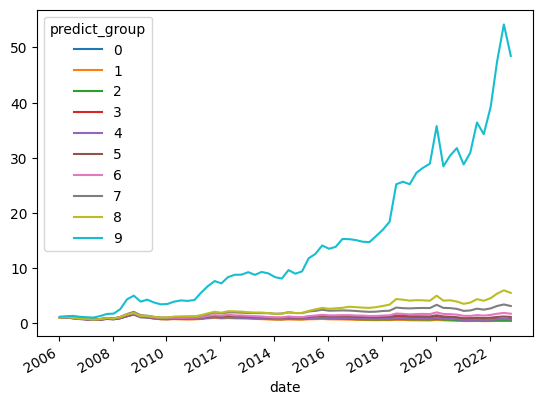

In [117]:
(b+1).cumprod().plot()

In [104]:
(b+1).prod()**(4/len(b))-1

predict_group
0   -0.0522
1   -0.0583
2   -0.0455
3   -0.0162
4   -0.0222
5    0.0054
6    0.0312
7    0.0685
8    0.1051
9    0.2564
dtype: float64

<Axes: ylabel='Frequency'>

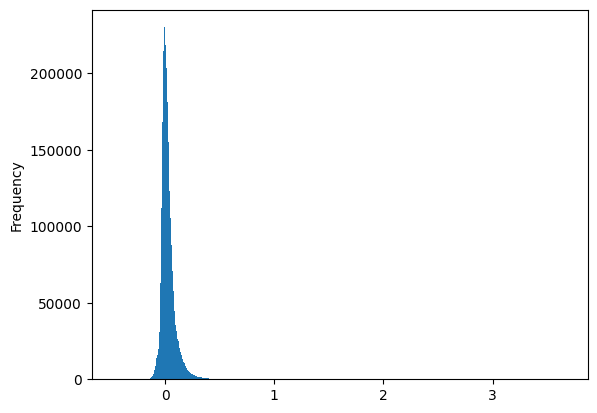

In [53]:
df_predict_all['predict'].plot.hist(bins=1000)

<Axes: ylabel='Frequency'>

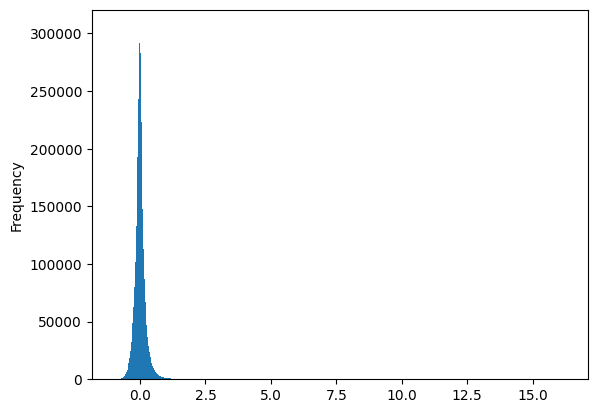

In [52]:
df_predict_all['y'].plot.hist(bins=1000)

<Axes: xlabel='predict', ylabel='y'>

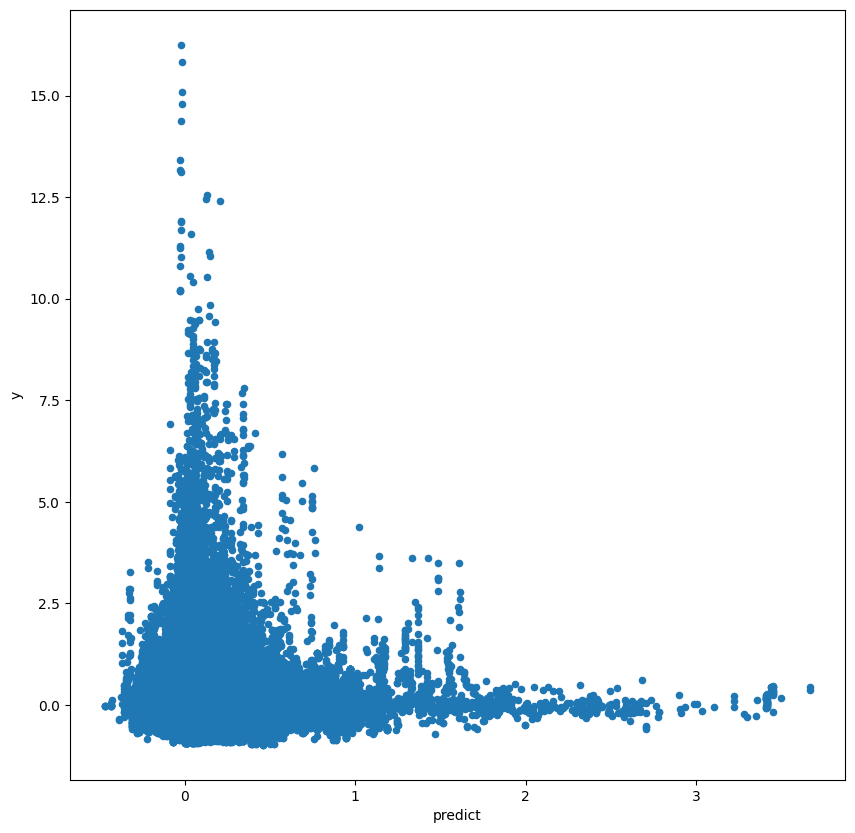

In [49]:
df_predict_all[['predict','y']].plot.scatter(x='predict', y='y', figsize=(10,10))